In [0]:
# Importing the required libraries:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install tf-nightly-gpu-2.0-preview
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# Uploading images from local directory to Google Colab:

from zipfile import ZipFile
file_name1 = '/ImageryNow.zip'

with ZipFile(file_name1, 'r') as zip1:
  zip1.extractall()
  
  
file_name2 = 'new_images_small_last.zip'

with ZipFile(file_name2, 'r') as zip2:
  zip2.extractall()
  
  
file_name3 = '/Images_test_now.zip'

with ZipFile(file_name3, 'r') as zip2:
  zip2.extractall()
  

In [0]:
# Indicating the path and creating the batches of data used for testing:
test_path= '/content/Images_test_now'
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), batch_size=4, shuffle=False)

Found 20 images belonging to 4 classes.


In [0]:
# Indicating the path and creating the data generator of the images for training:
base_dir = os.path.join('/content/', 'ImageryNow')

IMAGE_SIZE = 224
BATCH_SIZE = 16

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training',
    shuffle=True)


Found 448 images belonging to 4 classes.


In [0]:
# Take a look at the different types of coins included in the training:

print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Dime': 0, 'Nickle': 1, 'Penny': 2, 'Quarter': 3}


In [0]:
# Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [0]:
# Set all the layers for training on this images (In this case, none will be freezed):

base_model.trainable = True

In [0]:
#=========CODE TO FREEZE SOME LAYERS (50 LAYERS IN THIS CASE)===============
## Let's take a look to see how many layers are in the base model
#print("Number of layers in the base model: ", len(base_model.layers))

## Fine tune from this layer onwards
#fine_tune_at = 50

## Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#  layer.trainable =  False

Number of layers in the base model:  155


In [0]:
# Adding new training layers with a custom output of 4 classes, correspoding to
# the 4 types of coins:

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.000005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [0]:
# Showing a summary of the newly created model: 

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_10  (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 132       
Total params: 2,626,788
Trainable params: 2,592,676
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
# Start the training:

history=model.fit(train_generator,
                 epochs=25)

Train on 448 samples
Epoch 1/25
448/448 [==============================] - 10s 22ms/sample - loss: 1.6242 - accuracy: 0.3080
Epoch 2/25
448/448 [==============================] - 4s 9ms/sample - loss: 1.3023 - accuracy: 0.4152
Epoch 3/25
448/448 [==============================] - 4s 8ms/sample - loss: 1.1274 - accuracy: 0.5312
Epoch 4/25
448/448 [==============================] - 4s 8ms/sample - loss: 0.9429 - accuracy: 0.6496
Epoch 5/25
448/448 [==============================] - 4s 8ms/sample - loss: 0.9013 - accuracy: 0.6920
Epoch 6/25
448/448 [==============================] - 4s 8ms/sample - loss: 0.7593 - accuracy: 0.7545
Epoch 7/25
448/448 [==============================] - 4s 8ms/sample - loss: 0.6716 - accuracy: 0.8058
Epoch 8/25
448/448 [==============================] - 4s 8ms/sample - loss: 0.5717 - accuracy: 0.8549
Epoch 9/25
448/448 [==============================] - 4s 8ms/sample - loss: 0.5290 - accuracy: 0.8527
Epoch 10/25
448/448 [==============================] - 4s 8

Confusion matrix, without normalization
[[5 0 0 0]
 [0 4 0 1]
 [3 0 2 0]
 [0 0 0 5]]


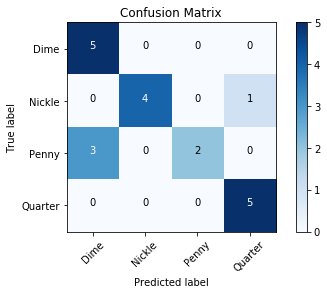

In [0]:
# Test the model on the test data, using the concept of confusion matrix:

from sklearn.metrics import confusion_matrix
import itertools

evaluated_batches = test_batches

test_labels = evaluated_batches.classes

def plot_confusion_matrix(cm, classes, 
                          normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

predictions = model.predict_generator(evaluated_batches, steps=5, verbose=0)
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
cm_plot_labels = ['Dime','Nickle','Penny','Quarter']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [0]:
# Saving the model in tflite format:

saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [0]:
# Downloading the model and a txt with the names of the different types of 
# coins, from Google Colab to the Downloads directory in the local disc.
# These are what will be used in the Andriod App:

from google.colab import files

files.download('model.tflite')
files.download('labels.txt')

In [0]:
# From this point on, code to show some of the test images with the
# correspoding predictions:

def plots(ims,figsize=(24,12), rows=1,interp=False, titles=None):
  if type(ims[0]) is np.ndarray:
    ims=np.array(ims).astype(np.uint8)
    if(ims.shape[-1]!=3):
      ims=ims.transpose((0,2,3,1))
  f=plt.figure(figsize=figsize)
  cols=len(ims)//rows if len(ims)%2==0 else len(ims)//rows+1
  for i in range(len(ims)):
    sp=f.add_subplot(cols,rows,i+1)
    sp.axis('Off')
    if titles is not None:
      sp.set_title(titles[i], fontsize=16)
    plt.imshow(ims[i], interpolation=None if interp else 'none')
  

In [0]:
imgs, labels= next(test_batches)

In [0]:
i=0

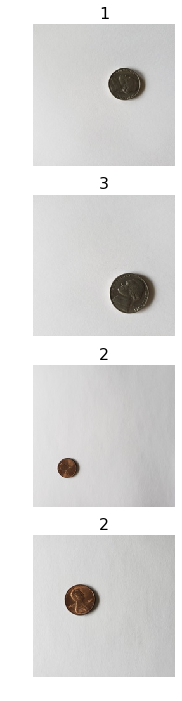

In [0]:

labels=np.argmax(predictions[i:i+4], axis=1)
imgs, labelss= next(test_batches)
plots(imgs, titles=labels)
i=i+4